# Used Packages

In [1]:
import os
import glob
import gc

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from datetime import datetime

from scipy.spatial.transform import Rotation as R

from utils.MovingAverager import *
from collections import defaultdict
from torchinfo import summary

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

# Global Variable

In [2]:
datapoint_per_second = 20
duration = 2
seq_len = 10

In [3]:
validation_traj = np.load(f'./npys/all_user_match_data.npy', allow_pickle=True)

In [4]:
def estimate_gravity(gravity_included_acceleration, dynamic_acceleration):
    raw_gravity_vector = np.array(gravity_included_acceleration) - np.array(dynamic_acceleration)
    gravity_direction = raw_gravity_vector / np.linalg.norm(raw_gravity_vector)
    return gravity_direction

In [5]:
def align_magnetometer_with_gravity(magnetometer_data, gravity_direction, num_of_axie):
    target_gravity_direction = np.array([0, 0, 1])
    rotation_vector = np.cross(gravity_direction, target_gravity_direction)
    rotation_vector_magnitude = np.linalg.norm(rotation_vector)
    if rotation_vector_magnitude == 0:
        return magnetometer_data  # 如果已经对齐，则不需要旋转
    rotation_vector /= rotation_vector_magnitude
    angle = np.arccos(np.dot(gravity_direction, target_gravity_direction))
    rotation = R.from_rotvec(rotation_vector * angle[:, np.newaxis])
    rotated_magnetometer_data = rotation.apply(magnetometer_data)
    hv = np.column_stack((np.sqrt(rotated_magnetometer_data[:, 0]**2 + rotated_magnetometer_data[:, 1]**2), rotated_magnetometer_data[:, 2]))
    return hv if num_of_axie == 2 else rotated_magnetometer_data

In [6]:
def get_data(validation_traj, num_of_axie, rotation):
    posture_data = defaultdict(list)

    valid_data = validation_traj.item()
    for user_name in valid_data.keys():
        for path_name in valid_data[user_name].keys():
            for posture_name in valid_data[user_name][path_name].keys():
                data = valid_data[user_name][path_name][posture_name]

                if posture_name == 'ref_mag':
                    if num_of_axie == 2:
                        posture_data[posture_name].append(data[:, [0, 1, 6, 7, 5]])
                    else:
                        posture_data[posture_name].append(data[:, [0, 1, 2, 3, 4, 6, 7, 5]])
                    continue

                pos = (data[:, [0, 1]] + np.array((1, 1))) * 0.6
                imu = data[:, [3, 4, 5, 6, 7, 8, 9, 10, 11]]
                mag = data[:, [12, 13, 14]]

                pos_mag = np.concatenate((pos, imu), axis=-1)

                if rotation:
                    gravity_direction = estimate_gravity(imu[:, 0:3], imu[:, 3:6])
                    mag = align_magnetometer_with_gravity(mag[:, 0:3], gravity_direction, num_of_axie)
                else:
                    if num_of_axie == 2: 
                        mag = np.column_stack((np.sqrt(np.sum(mag[:, :2]**2, axis=1)), mag[:, 2]))
                pos_mag = np.concatenate((pos_mag, mag, data[:, [15]]), axis=-1)            
                posture_data[posture_name].append(pos_mag)
    return posture_data

In [7]:
def split_traj(trajs, length=20):
    sp_traj = []
    for traj in trajs:
        for i in range(len(traj) - length + 1):
            sp_traj.append(traj[i:i+length])
    return np.array(sp_traj)

# Data Loader

In [8]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        assert (source_data.shape[0] == source_label.shape[0] == target_data.shape[0] == target_label.shape[0]), f'{source_data.shape}, {source_label.shape}, {target_data.shape}, {target_label.shape}'
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]

In [9]:
def for_dataloaders(traj, gt='target'):
    t_data = 0
    t_label = 0
    t_target_data = 0
    v_data = 0
    v_label = 0
    v_target_data = 0
    label = 1
    label_dict = {}
    flag = False
    for key, value in traj.items():
        split = int(len(value) * 9 / 10)
        tmp1, tmp2 = value[:split], value[split:]
        if key != gt: 
            t_data = np.concatenate((t_data, tmp1)) if flag else tmp1
            t_label = np.concatenate((t_label, np.full((tmp1.shape[0], ), label))) if flag else np.full((tmp1.shape[0], ), label)
            v_data = np.concatenate((v_data, tmp2)) if flag else tmp2
            v_label = np.concatenate((v_label, np.full((tmp2.shape[0], ), label))) if flag else np.full((tmp2.shape[0], ), label)
            flag = True
            label_dict[label] = key
            label += 1
        else:
            t_target_data = np.tile(tmp1, (4, 1, 1))
            v_target_data = np.tile(tmp2, (4, 1, 1))
            label_dict[0] = key
    
    train_dataset = PairDataset(
                        source_data = torch.tensor(t_data, dtype=torch.float),
                        source_label = t_label,
                        target_data = torch.tensor(t_target_data, dtype=torch.float),
                        target_label = np.zeros((len(t_target_data), ))
                    )
    
    valid_dataset = PairDataset(
                        source_data = torch.tensor(v_data, dtype=torch.float),
                        source_label = v_label,
                        target_data = torch.tensor(v_target_data, dtype=torch.float),
                        target_label = np.zeros((len(v_target_data), ))
                    )

    print(label_dict)
    return label_dict, train_dataset, valid_dataset

# Model Declaration

In [10]:
class FirstDerivativeLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean'):
        super(FirstDerivativeLoss, self).__init__()

    def forward(self, source, target):
        # calculate the first derivative
        source_o = torch.reshape(source, (len(source), -1))
        target_o = torch.reshape(target, (len(target), -1))
        d_source = source_o[1:] - source_o[:-1]
        d_target = target_o[1:] - target_o[:-1]
        deriv = d_source - d_target

        # calculate the loss as the mean squared error of the derivative
        loss = torch.mean(torch.pow(deriv, 2))

        return loss

In [11]:
def generator_loss(z_imu, target_imu, predict_mag, target_mag, source_total_mag, target_total_mag):
    imu_loss = mse_loss(z_imu, target_imu)
    mag_loss = mse_loss(predict_mag, target_mag)
    d1_loss = div_loss(predict_mag, target_mag)
    
    pred_total_mag = torch.sqrt(torch.sum(torch.pow(predict_mag, 2), dim=-1))
    
    smag_limitation_loss = torch.mean(torch.abs(pred_total_mag - source_total_mag))
    tmag_limitation_loss = torch.mean(torch.abs(pred_total_mag - target_total_mag))

    total_loss = imu_loss + mag_loss + 2 * d1_loss + smag_limitation_loss * 0.25 + tmag_limitation_loss * 0.75
    return total_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss)

In [12]:
num_of_classes = 4
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
bce_loss = torch.nn.BCELoss()
div_loss = FirstDerivativeLoss()

In [13]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    return mask

In [14]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    

class NotSimpleTransformer(nn.Module):
    def __init__(self, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        self.mag_axis = num_of_axie
        
        self.imu_layer = nn.Sequential(
            nn.Linear(9, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 64),
            nn.LeakyReLU(),
        )
        self.mag_layer = nn.Sequential(
            nn.Linear(self.mag_axis, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 64),
            nn.LeakyReLU(),
        )
        self.pos_encoder = PositionalEncoding(64, 0.1)
        
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=1)
        self.nn = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 9),
            nn.LeakyReLU(),
        )
        
        self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=1)
        
        self.mag_last = nn.Sequential(
            nn.Linear(64, 16),
            nn.LeakyReLU(),
            nn.Linear(16, self.mag_axis),
        )
        
    def forward(self, source_imu, source_mag):
        
        ### step 1
        h_imu = self.imu_layer(source_imu)
        h_imu = self.pos_encoder(h_imu)
        
        h_mag = self.mag_layer(source_mag)
        h_mag = self.pos_encoder(h_mag)
        
        ### step 2
        z = self.encoder(h_imu)
        z_imu = self.nn(z)
        
        ### step 3
        pred_latent = self.decoder(h_mag, z)
        pred_mag = self.mag_last(pred_latent)
        
        return z_imu, pred_mag

In [15]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.lstm1 = nn.LSTM(input_size=32, hidden_size=128, batch_first=True)  # 条件维度2
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, batch_first=True)  # 条件维度2
        self.fc = nn.Linear(256, 9)  # 输出维度为9，每个序列元素
        self.batchnorm = nn.BatchNorm1d(256)

    def forward(self, noise, conditions):
        combined_input = torch.cat([noise, conditions], dim=2)  # 合并噪声和条件
        output, _ = self.lstm1(combined_input)
        output, _ = self.lstm2(output)
        output = self.batchnorm(output.transpose(1, 2)).transpose(1, 2)
        return self.fc(output)  # 输出batch_size * sequence_length * 9

In [16]:
generator =torch.load('/root/Calibration/R403/generator.pt').to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

In [17]:
# summary(model, input_size=[(1, 10, 9), (1, 10, 2)])

In [18]:
def plot_result(result, source_label=None):
    pred_mag = result[0].reshape(-1, num_of_axie)
    targ_mag = result[1].reshape(-1, num_of_axie)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'][:num_of_axie], ['tab:blue', 'tab:orange', 'tab:green'][:num_of_axie]):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    pred_total_mag = np.sqrt(np.sum(np.power(pred_mag, 2), axis=-1))
    targ_total_mag = np.sqrt(np.sum(np.power(targ_mag, 2), axis=-1))
    plt.plot(x, pred_total_mag, label=f'pred_t', color='tab:red', linewidth=2.5, zorder=2)
    plt.plot(x, targ_total_mag, '--', label=f'targ_t', color='tab:red', linewidth=1, alpha=0.8, zorder=1)
    
    if source_label != None:
        plt.suptitle(f'{classes[source_label]}   Loss: {loss:.2f}')
    else:
        plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [19]:
def train(dataloader, draw=False):
    model.train()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    lim_loss = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        source_data = source_data.to(device)
        source_imu = source_data[:, :, 2:11] + torch.randn_like(source_data[:, :, 2:11]) * 0.25
        source_mag = source_data[:, :, 11:(11 + num_of_axie)] + torch.randn_like(source_data[:, :, 11:(11 + num_of_axie)]) * 0.5
        source_total_mag = source_data[:, :, -1]
        
        with torch.no_grad():
            target_data = target_data.to(device)
            target_imu = generator(target_data[:, :, 0:2], torch.zeros(target_data[:, :, 0:2].size(0), target_data[:, :, 0:2].size(1), 30, device=device))
            target_mag = target_data[:, :, 2:(2 + num_of_axie)]
            target_total_mag = target_data[:, :, -1]

        # generate mag
        z_imu, predict_mag = model(source_imu, source_mag)
        
        # generator loss
        gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag,
                                                                                              source_total_mag, target_total_mag)
        
        # backward
        gen_loss.backward()
        optimizer.step()
        
        # record loss
        g_losses.append(gen_loss.item())
        imu_losses.append(imu_loss.item())
        mag_losses.append(mag_loss.item())
        d1_losses.append(d1_loss.item())
        lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

In [20]:
def evalute(dataloader, draw=False):
    model.eval()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    lim_loss = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, 2:11]
            source_mag = source_data[:, :, 11:(11 + num_of_axie)]
            source_total_mag = source_data[:, :, -1]

            target_data = target_data.to(device)
            target_imu = generator(target_data[:, :, 0:2], torch.zeros(target_data[:, :, 0:2].size(0), target_data[:, :, 0:2].size(1), 30, device=device))
            target_mag = target_data[:, :, 2:(2 + num_of_axie)]
            target_total_mag = target_data[:, :, -1]
            
            # generate mag
            z_imu, predict_mag = model(source_imu, source_mag)

            # generator loss
            gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag,
                                                                                                  source_total_mag, target_total_mag)

            # record loss
            g_losses.append(gen_loss.item())
            imu_losses.append(imu_loss.item())
            mag_losses.append(mag_loss.item())
            d1_losses.append(d1_loss.item())
            lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

In [21]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    class_results = []
    class_labels = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_pos = source_data[:, :, :2]
            source_imu = source_data[:, :, 2:11]
            source_mag = source_data[:, :, 11:(11 + num_of_axie)]

            target_data = target_data.to(device)
            target_imu = generator(target_data[:, :, 0:2], torch.zeros(target_data[:, :, 0:2].size(0), target_data[:, :, 0:2].size(1), 30, device=device))
            target_pos = target_data[:, :, :2]
            target_mag = target_data[:, :, 2:(2 + num_of_axie)]
            target_total_mag = target_data[:, :, -1]

            # generate mag
            z_imu, predict_mag = model(source_imu, source_mag)

            # generator loss
#             gen_loss, imu_loss, mag_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            predict_mag = predict_mag.detach().cpu().numpy()
            target_pos = target_pos.detach().cpu().numpy()
            target_mag = target_mag.cpu().numpy()
            source_label = source_label.detach().cpu().numpy()
            
            results.extend(zip(predict_mag, target_mag, source_label, target_pos))
            
            diff = np.power(predict_mag.reshape(len(predict_mag), -1, num_of_axie) - target_mag.reshape(len(target_mag), -1, num_of_axie), 2).mean(axis=1)
            class_results.extend(diff)
            class_labels.extend(source_label)
    
    return np.array(results, dtype=object), np.array(class_results), np.array(class_labels)

In [22]:
def show_result(model, dataloader):
    results, cres, clabel = output_eval(model, dataloader)
    print(results.shape, cres.shape, clabel.shape)

    if num_of_axie == 3:
        print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
        for class_label, class_name in classes.items():
            if sum(clabel == class_label) <= 0:
                continue
            dx, dy, dz = cres[clabel == class_label].mean(axis=0)
            print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
        dx, dy, dz = cres.mean(axis=0)
        print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
    
    elif num_of_axie == 2:
        print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"avg":>8}')
        for class_label, class_name in classes.items():
            if sum(clabel == class_label) <= 0:
                continue
            dx, dy = cres[clabel == class_label].mean(axis=0)
            print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {np.mean([dx, dy]):>8.2f}')
        dx, dy = cres.mean(axis=0)
        print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {np.mean([dx, dy]):>8.2f}')

    for rs, rl in zip(results[::500], clabel[::50]):
        plot_result(rs, rl)

# Experiment 1
rotation = False
num_of_axie = 2 Different final ground truth (最終姿態)

In [23]:
num_of_axie, rotation = 2, True
posture_data = get_data(validation_traj, num_of_axie, rotation)
prep_valid_traj = defaultdict(np.array)

prep_valid_traj['front_pocket'] = split_traj(posture_data['front_pocket'])
prep_valid_traj['pocket']       = split_traj(posture_data['pocket'])
prep_valid_traj['swing']        = split_traj(posture_data['swing'])
prep_valid_traj['target']       = split_traj(posture_data['target'])
prep_valid_traj['ref_mag']      = split_traj(posture_data['ref_mag'])

classes, train_dataset, valid_dataset = for_dataloaders(prep_valid_traj, gt='ref_mag')
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

{1: 'front_pocket', 2: 'pocket', 3: 'swing', 4: 'target', 0: 'ref_mag'}


01000: train loss: 71.176, imu loss:  2.975, mag loss: 13.025, div loss: 26.255, slim:  3.140, tlim:  2.509
       valid loss: 71.939, imu loss:  3.050, mag loss: 50.521, div loss:  7.329, slim:  4.275, tlim:  3.521
02000: train loss: 52.003, imu loss:  2.922, mag loss:  9.329, div loss: 18.677, slim:  3.163, tlim:  2.143
       valid loss: 75.826, imu loss:  3.028, mag loss: 52.025, div loss:  8.445, slim:  4.410, tlim:  3.707
03000: train loss: 42.482, imu loss:  2.894, mag loss:  7.511, div loss: 14.933, slim:  3.147, tlim:  1.902
       valid loss: 75.464, imu loss:  3.020, mag loss: 51.147, div loss:  8.794, slim:  4.172, tlim:  3.553
04000: train loss: 36.465, imu loss:  2.873, mag loss:  6.329, div loss: 12.592, slim:  3.135, tlim:  1.728
       valid loss: 74.308, imu loss:  3.015, mag loss: 50.484, div loss:  8.679, slim:  3.890, tlim:  3.304
05000: train loss: 32.208, imu loss:  2.855, mag loss:  5.525, div loss: 10.925, slim:  3.143, tlim:  1.591
       valid loss: 74.134, i

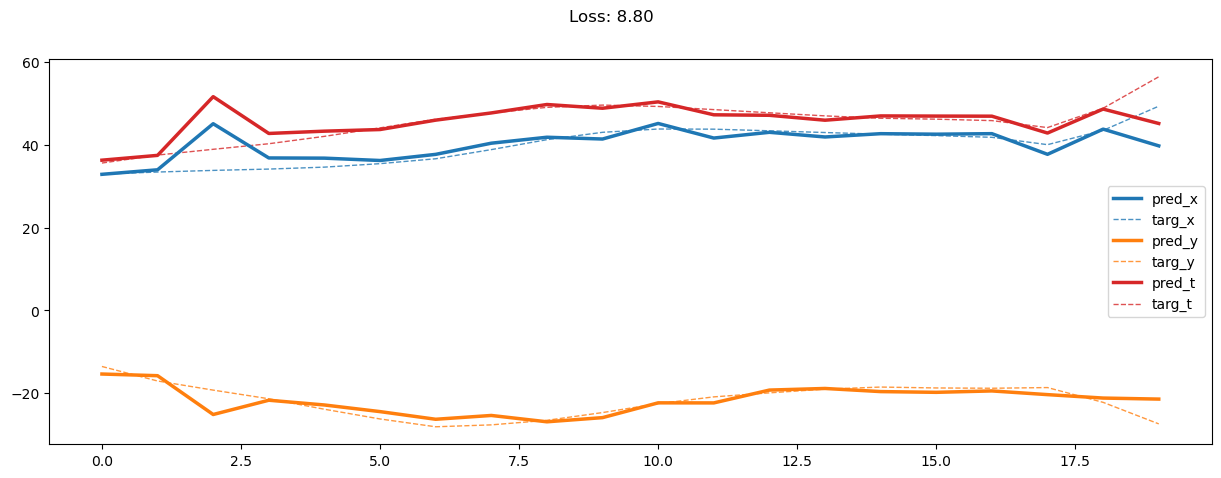

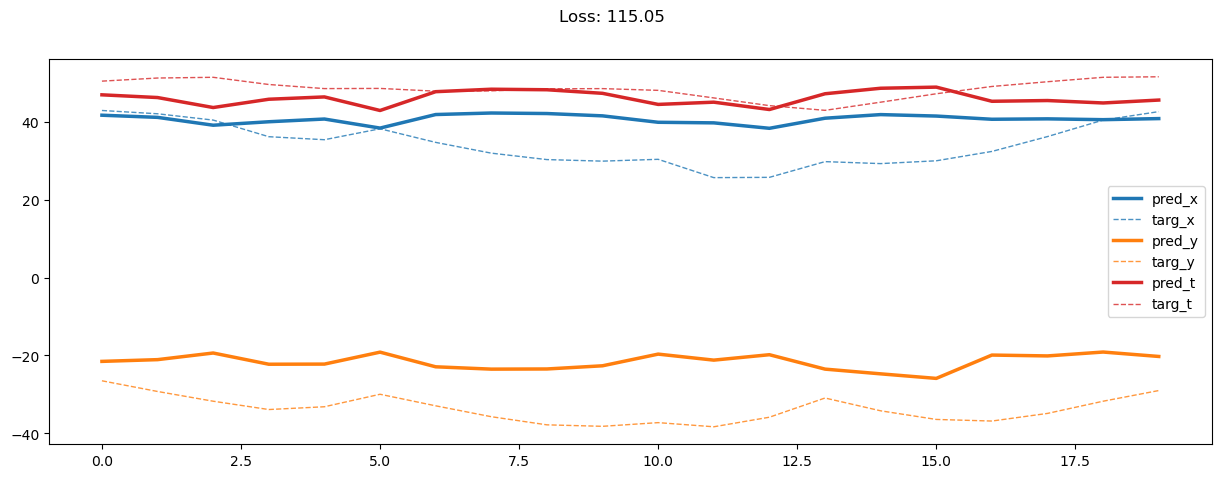

20000: train loss: 18.265, imu loss:  2.669, mag loss:  2.819, div loss:  5.582, slim:  3.245, tlim:  1.071
       valid loss: 76.069, imu loss:  3.099, mag loss: 48.872, div loss: 10.373, slim:  3.828, tlim:  3.193


In [24]:
EPOCH = 20000
draw = False

for epoch in range(EPOCH):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    
    draw = ((epoch + 1) % EPOCH == 0)
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss, tlim_loss = train(train_loader, draw)
    
    if (epoch + 1) % 1000 == 0:
        valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss, vlim_loss = evalute(valid_loader, draw)
        print(f'{epoch+1:05d}: train loss: {train_loss:>6.3f}, imu loss: {train_imu_loss:>6.3f}, mag loss: {train_mag_loss:>6.3f}, div loss: {t_d1_loss:>6.3f}, slim: {tlim_loss[0]:>6.3f}, tlim: {tlim_loss[1]:>6.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss:>6.3f}, imu loss: {valid_imu_loss:>6.3f}, mag loss: {valid_mag_loss:>6.3f}, div loss: {v_d1_loss:>6.3f}, slim: {vlim_loss[0]:>6.3f}, tlim: {vlim_loss[1]:>6.3f}')

(2424, 4) (2424, 2) (2424,)
           loss name|   diff x   diff y      avg
   front_pocket loss:     1.64     1.59     1.62
         pocket loss:     1.61     1.72     1.66
          swing loss:     1.37     1.34     1.36
         target loss:     1.86     1.98     1.92
        average loss:     1.62     1.66     1.64


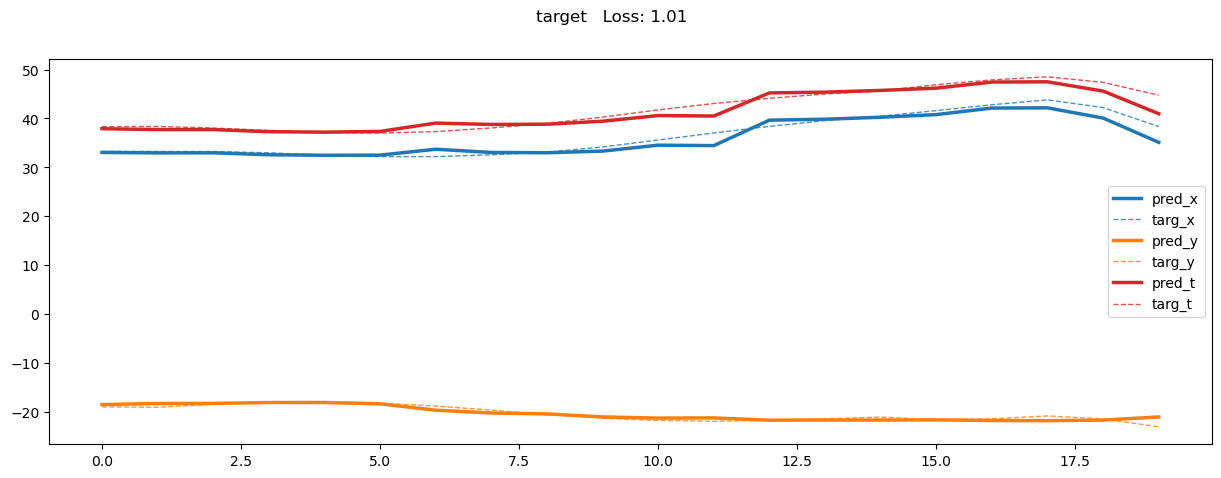

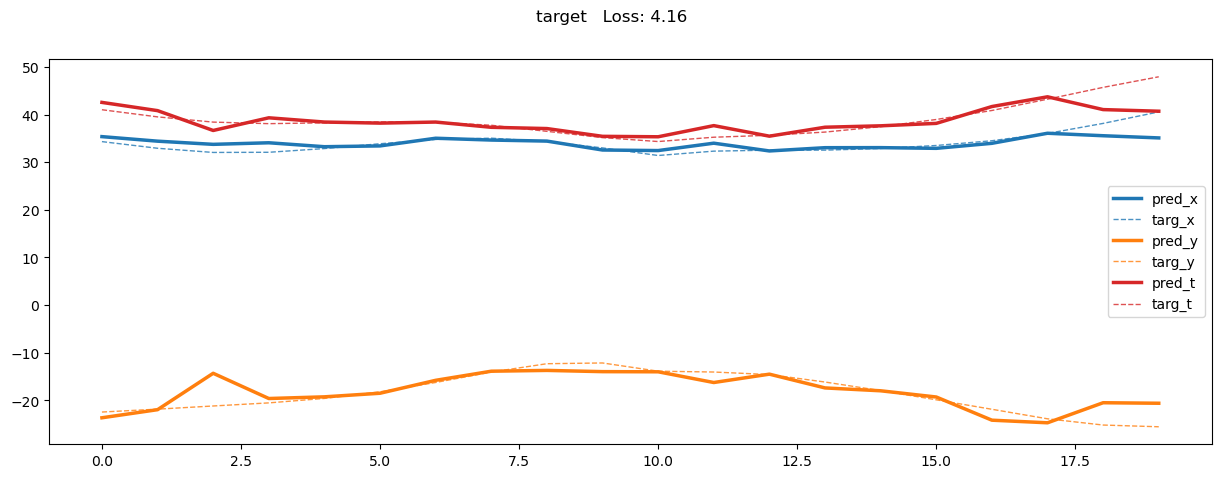

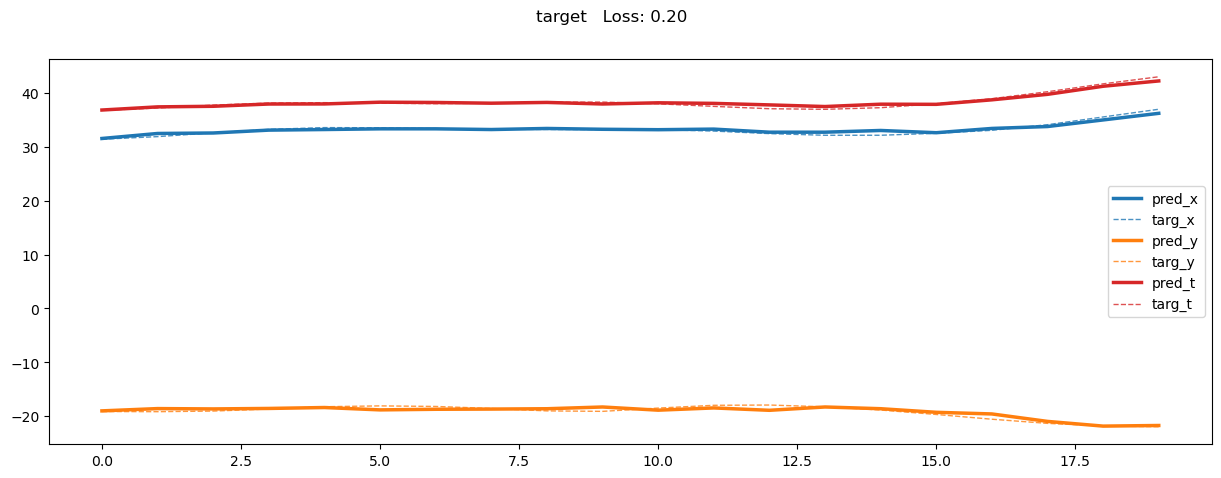

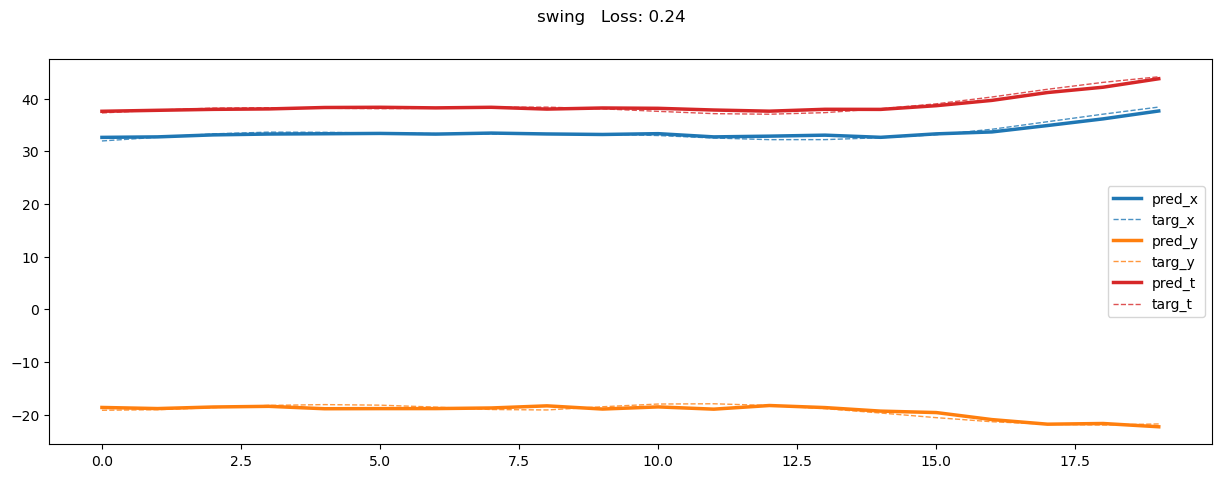

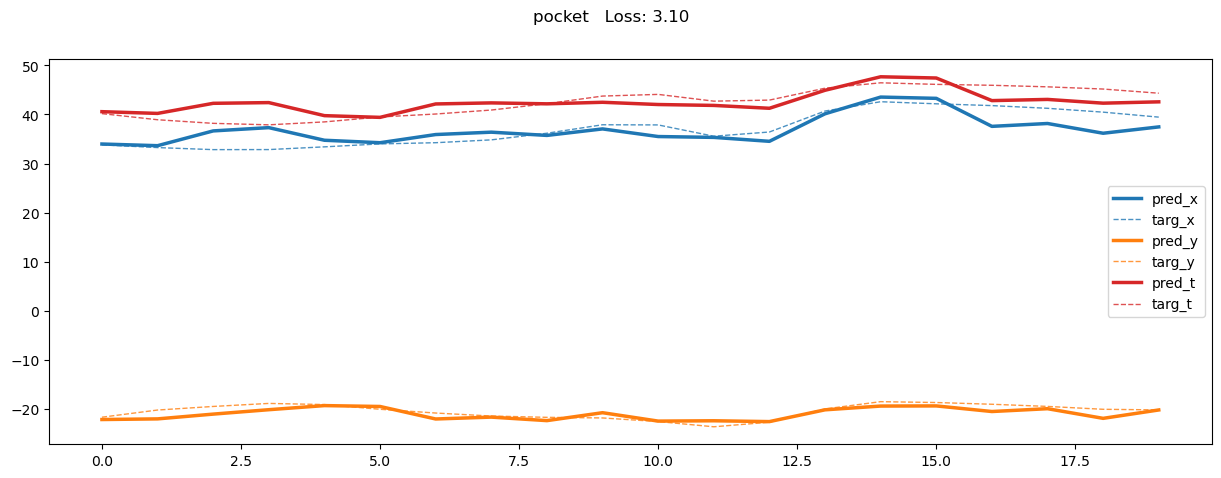

In [25]:
show_result(model, train_loader)

(272, 4) (272, 2) (272,)
           loss name|   diff x   diff y      avg
   front_pocket loss:    41.13    71.39    56.26
         pocket loss:    23.22    41.51    32.37
          swing loss:    28.57    57.05    42.81
         target loss:    28.55    54.29    41.42
        average loss:    30.37    56.06    43.21


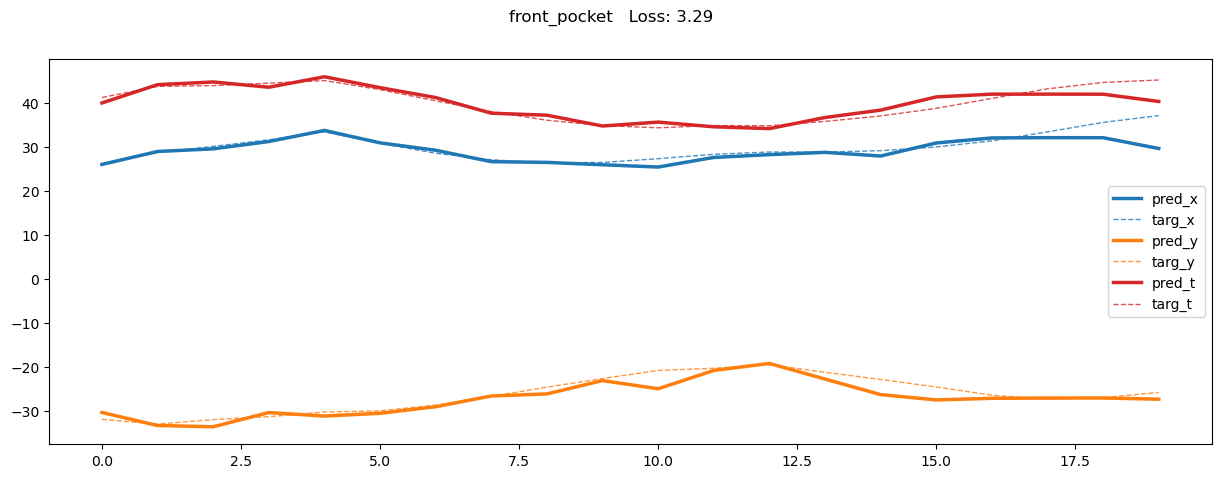

In [26]:
show_result(model, valid_loader)

In [27]:
torch.save(model, f'./model/ft_rotation/transformer_{num_of_axie}_{int(rotation)}.pt')
model.cpu()
del model, optimizer, train_loader, valid_loader, train_dataset, valid_dataset
gc.collect()
torch.cuda.empty_cache()

# Experiment 2
rotation = False
num_of_axie = 2 Different final ground truth (最終姿態)

In [28]:
num_of_axie, rotation = 2, False
posture_data = get_data(validation_traj, num_of_axie, rotation)
prep_valid_traj = defaultdict(np.array)

prep_valid_traj['front_pocket'] = split_traj(posture_data['front_pocket'])
prep_valid_traj['pocket']       = split_traj(posture_data['pocket'])
prep_valid_traj['swing']        = split_traj(posture_data['swing'])
prep_valid_traj['target']       = split_traj(posture_data['target'])
prep_valid_traj['ref_mag']      = split_traj(posture_data['ref_mag'])

classes, train_dataset, valid_dataset = for_dataloaders(prep_valid_traj, gt='ref_mag')
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

{1: 'front_pocket', 2: 'pocket', 3: 'swing', 4: 'target', 0: 'ref_mag'}


00999: train loss: 74.392, imu loss:  2.990, mag loss: 13.702, div loss: 27.511, slim:  3.116, tlim:  2.531
       valid loss: 68.062, imu loss:  3.061, mag loss: 48.207, div loss:  6.570, slim:  4.059, tlim:  3.517
01999: train loss: 52.516, imu loss:  2.926, mag loss:  9.452, div loss: 18.881, slim:  3.138, tlim:  2.122
       valid loss: 70.980, imu loss:  3.014, mag loss: 49.933, div loss:  7.240, slim:  4.067, tlim:  3.381
02999: train loss: 42.293, imu loss:  2.890, mag loss:  7.500, div loss: 14.860, slim:  3.124, tlim:  1.871
       valid loss: 68.753, imu loss:  3.011, mag loss: 46.554, div loss:  7.883, slim:  3.950, tlim:  3.245
03999: train loss: 36.573, imu loss:  2.873, mag loss:  6.337, div loss: 12.651, slim:  3.130, tlim:  1.704
       valid loss: 68.313, imu loss:  3.010, mag loss: 46.365, div loss:  7.813, slim:  3.838, tlim:  3.135
04999: train loss: 32.024, imu loss:  2.860, mag loss:  5.453, div loss: 10.872, slim:  3.139, tlim:  1.576
       valid loss: 66.894, i

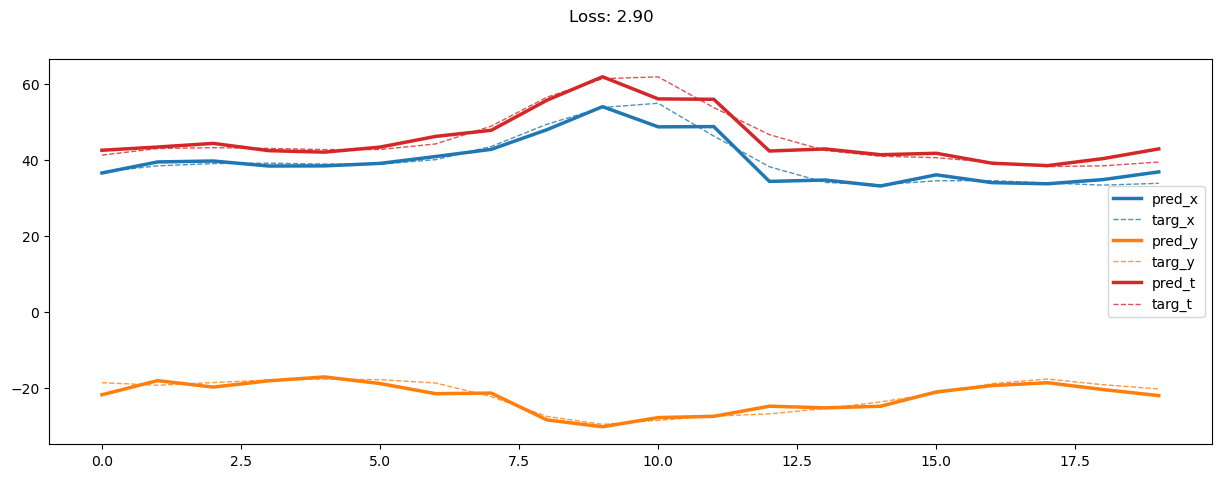

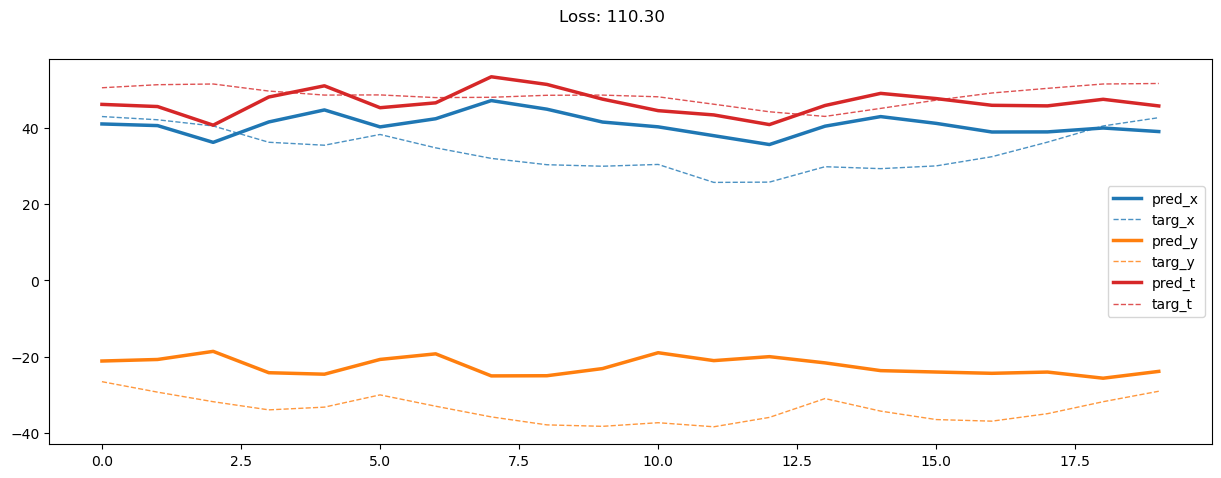

19999: train loss: 18.982, imu loss:  2.685, mag loss:  2.949, div loss:  5.863, slim:  3.271, tlim:  1.072
       valid loss: 69.621, imu loss:  3.069, mag loss: 47.256, div loss:  8.096, slim:  3.627, tlim:  2.929


In [29]:
EPOCH = 20000
draw = False

for epoch in range(EPOCH):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    
    draw = ((epoch + 1) % EPOCH == 0)
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss, tlim_loss = train(train_loader, draw)
    
    if (epoch + 1) % 1000 == 0:
        valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss, vlim_loss = evalute(valid_loader, draw)
        print(f'{epoch:05d}: train loss: {train_loss:>6.3f}, imu loss: {train_imu_loss:>6.3f}, mag loss: {train_mag_loss:>6.3f}, div loss: {t_d1_loss:>6.3f}, slim: {tlim_loss[0]:>6.3f}, tlim: {tlim_loss[1]:>6.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss:>6.3f}, imu loss: {valid_imu_loss:>6.3f}, mag loss: {valid_mag_loss:>6.3f}, div loss: {v_d1_loss:>6.3f}, slim: {vlim_loss[0]:>6.3f}, tlim: {vlim_loss[1]:>6.3f}')

(2424, 4) (2424, 2) (2424,)
           loss name|   diff x   diff y      avg
   front_pocket loss:     1.75     1.75     1.75
         pocket loss:     1.67     1.86     1.76
          swing loss:     1.41     1.51     1.46
         target loss:     1.77     1.86     1.81
        average loss:     1.65     1.75     1.70


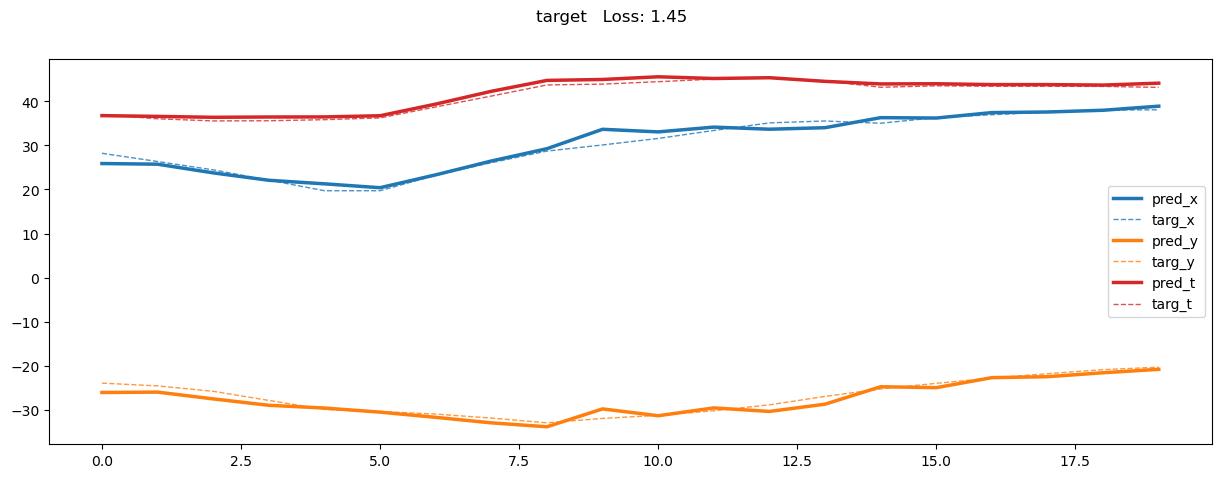

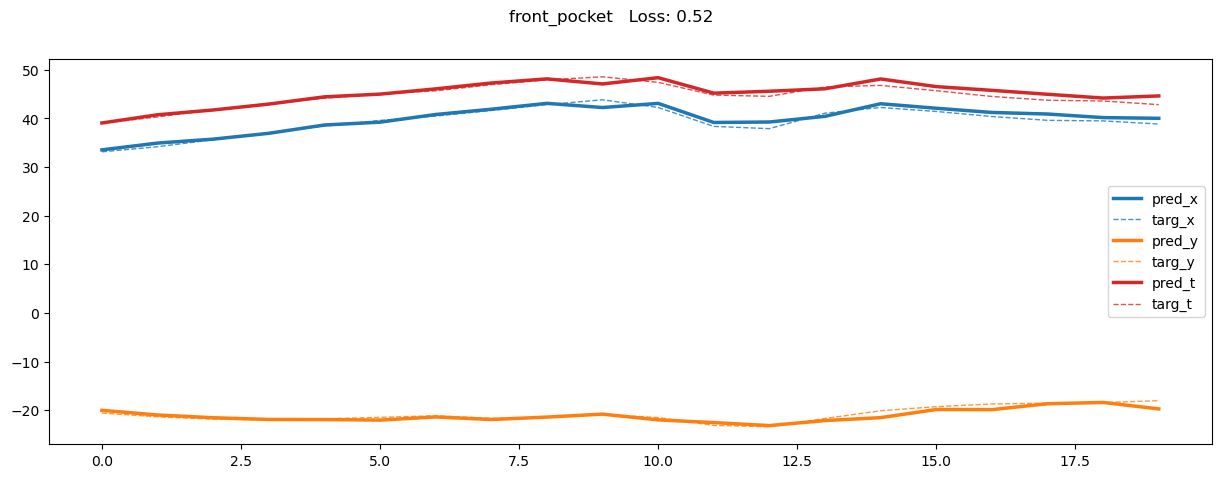

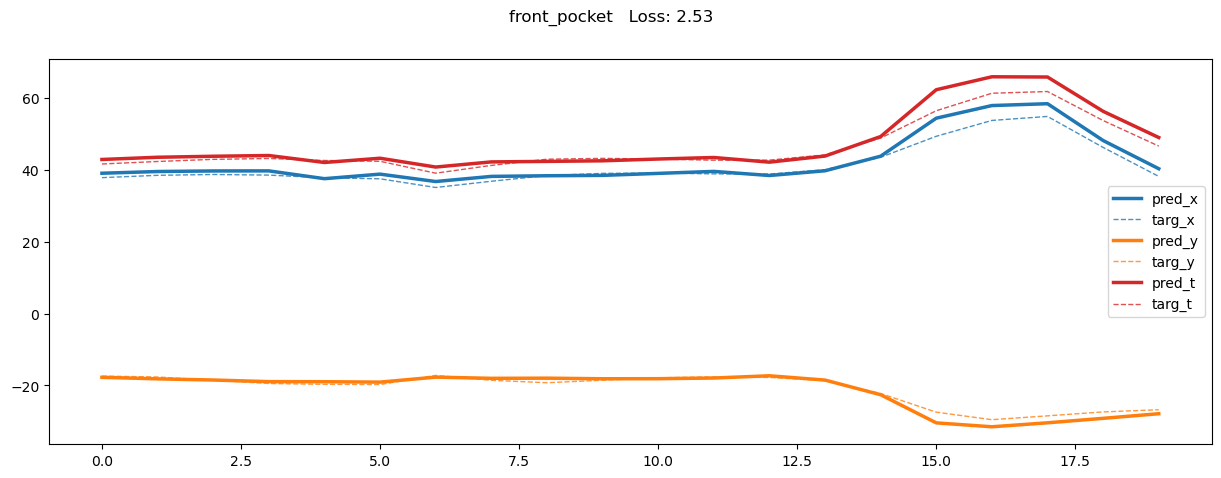

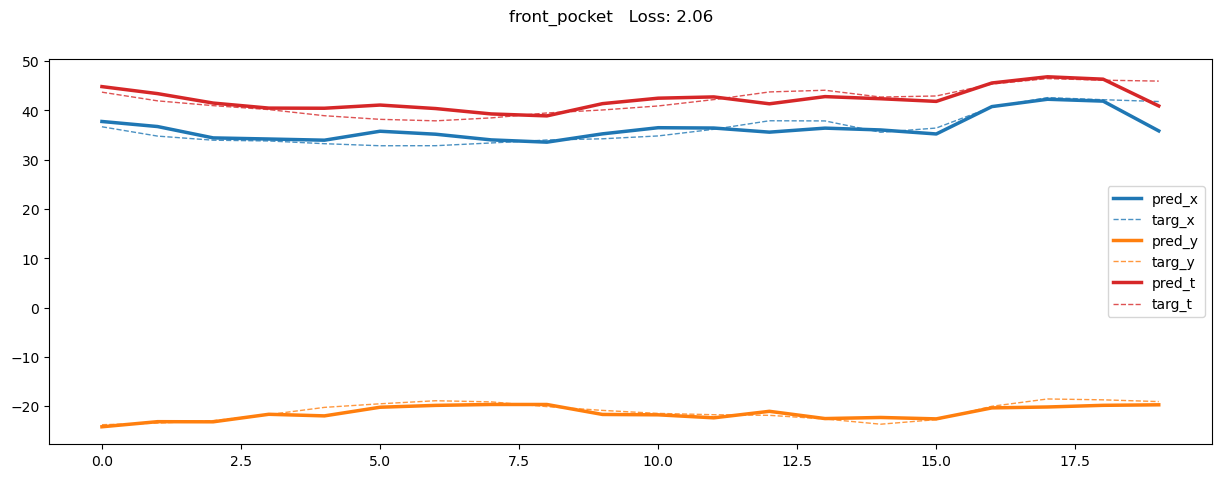

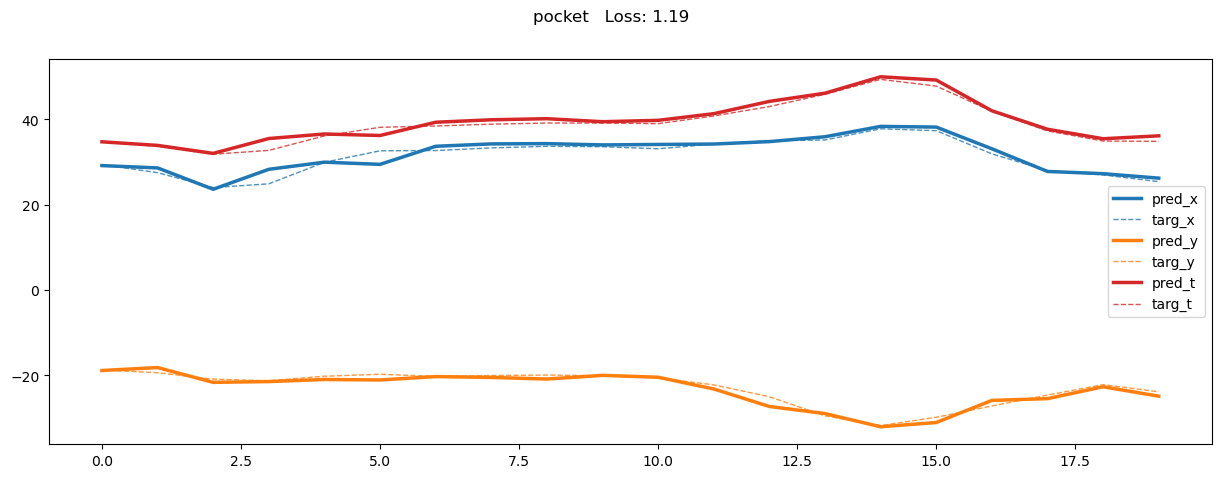

In [30]:
show_result(model, train_loader)

(272, 4) (272, 2) (272,)
           loss name|   diff x   diff y      avg
   front_pocket loss:    38.14    64.39    51.26
         pocket loss:    26.78    70.59    48.69
          swing loss:    25.22    37.21    31.21
         target loss:    26.33    48.66    37.50
        average loss:    29.12    55.21    42.17


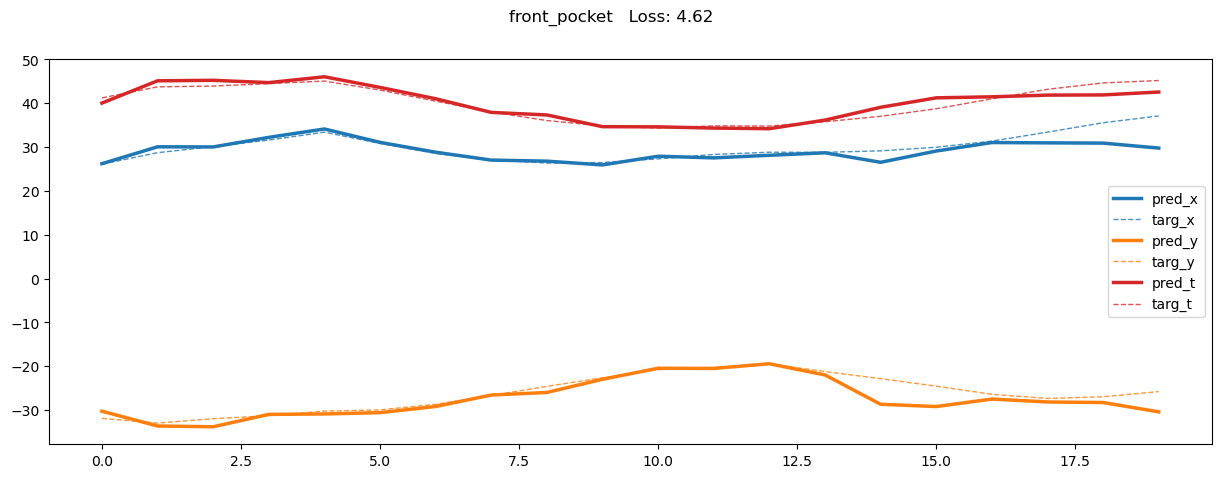

In [31]:
show_result(model, valid_loader)

In [32]:
torch.save(model, f'./model/ft_rotation/transformer_{num_of_axie}_{int(rotation)}.pt')
model.cpu()
del model, optimizer, train_loader, valid_loader, train_dataset, valid_dataset
gc.collect()
torch.cuda.empty_cache()

# Experiment 3
rotation = True
num_of_axie = 3 Different final ground truth (最終姿態)

In [33]:
num_of_axie, rotation = 3, True
posture_data = get_data(validation_traj, num_of_axie, rotation)
prep_valid_traj = defaultdict(np.array)

prep_valid_traj['front_pocket'] = split_traj(posture_data['front_pocket'])
prep_valid_traj['pocket']       = split_traj(posture_data['pocket'])
prep_valid_traj['swing']        = split_traj(posture_data['swing'])
prep_valid_traj['target']       = split_traj(posture_data['target'])
prep_valid_traj['ref_mag']      = split_traj(posture_data['ref_mag'])

classes, train_dataset, valid_dataset = for_dataloaders(prep_valid_traj, gt='ref_mag')
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

{1: 'front_pocket', 2: 'pocket', 3: 'swing', 4: 'target', 0: 'ref_mag'}


In [ ]:
EPOCH = 20000
draw = False

for epoch in range(EPOCH):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    
    draw = ((epoch + 1) % EPOCH == 0)
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss, tlim_loss = train(train_loader, draw)
    
    if (epoch + 1) % 1000 == 0:
        valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss, vlim_loss = evalute(valid_loader, draw)
        print(f'{epoch:05d}: train loss: {train_loss:>6.3f}, imu loss: {train_imu_loss:>6.3f}, mag loss: {train_mag_loss:>6.3f}, div loss: {t_d1_loss:>6.3f}, slim: {tlim_loss[0]:>6.3f}, tlim: {tlim_loss[1]:>6.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss:>6.3f}, imu loss: {valid_imu_loss:>6.3f}, mag loss: {valid_mag_loss:>6.3f}, div loss: {v_d1_loss:>6.3f}, slim: {vlim_loss[0]:>6.3f}, tlim: {vlim_loss[1]:>6.3f}')

00999: train loss: 61.248, imu loss:  2.973, mag loss: 11.159, div loss: 22.271, slim:  3.361, tlim:  2.311
       valid loss: 62.010, imu loss:  3.023, mag loss: 40.935, div loss:  6.667, slim:  5.420, tlim:  4.484
01999: train loss: 43.165, imu loss:  2.914, mag loss:  7.608, div loss: 15.189, slim:  3.334, tlim:  1.908
       valid loss: 62.338, imu loss:  3.015, mag loss: 40.607, div loss:  7.061, slim:  5.425, tlim:  4.317
02999: train loss: 35.376, imu loss:  2.884, mag loss:  6.090, div loss: 12.151, slim:  3.313, tlim:  1.696
       valid loss: 58.959, imu loss:  3.013, mag loss: 37.703, div loss:  6.976, slim:  5.106, tlim:  4.019
03999: train loss: 29.758, imu loss:  2.854, mag loss:  5.006, div loss:  9.974, slim:  3.287, tlim:  1.506
       valid loss: 58.598, imu loss:  3.013, mag loss: 37.376, div loss:  7.066, slim:  4.825, tlim:  3.828
04999: train loss: 26.437, imu loss:  2.836, mag loss:  4.369, div loss:  8.686, slim:  3.275, tlim:  1.387
       valid loss: 57.496, i

In [ ]:
show_result(model, train_loader)

In [ ]:
show_result(model, valid_loader)

In [ ]:
torch.save(model, f'./model/ft_rotation/transformer_{num_of_axie}_{int(rotation)}.pt')
model.cpu()
del model, optimizer, train_loader, valid_loader, train_dataset, valid_dataset
gc.collect()
torch.cuda.empty_cache()

# Experiment 4
rotation = False
num_of_axie = 3 Different final ground truth (最終姿態)

In [ ]:
num_of_axie, rotation = 3, False
posture_data = get_data(validation_traj, num_of_axie, rotation)
prep_valid_traj = defaultdict(np.array)

prep_valid_traj['front_pocket'] = split_traj(posture_data['front_pocket'])
prep_valid_traj['pocket']       = split_traj(posture_data['pocket'])
prep_valid_traj['swing']        = split_traj(posture_data['swing'])
prep_valid_traj['target']       = split_traj(posture_data['target'])
prep_valid_traj['ref_mag']      = split_traj(posture_data['ref_mag'])

classes, train_dataset, valid_dataset = for_dataloaders(prep_valid_traj, gt='ref_mag')
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

In [ ]:
EPOCH = 20000
draw = False

for epoch in range(EPOCH):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    
    draw = ((epoch + 1) % EPOCH == 0)
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss, tlim_loss = train(train_loader, draw)
    
    if (epoch + 1) % 1000 == 0:
        valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss, vlim_loss = evalute(valid_loader, draw)
        print(f'{epoch:05d}: train loss: {train_loss:>6.3f}, imu loss: {train_imu_loss:>6.3f}, mag loss: {train_mag_loss:>6.3f}, div loss: {t_d1_loss:>6.3f}, slim: {tlim_loss[0]:>6.3f}, tlim: {tlim_loss[1]:>6.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss:>6.3f}, imu loss: {valid_imu_loss:>6.3f}, mag loss: {valid_mag_loss:>6.3f}, div loss: {v_d1_loss:>6.3f}, slim: {vlim_loss[0]:>6.3f}, tlim: {vlim_loss[1]:>6.3f}')

In [ ]:
show_result(model, train_loader)

In [ ]:
show_result(model, valid_loader)

In [ ]:
torch.save(model, f'./model/ft_rotation/transformer_{num_of_axie}_{int(rotation)}.pt')
model.cpu()
del model, optimizer, train_loader, valid_loader, train_dataset, valid_dataset
gc.collect()
torch.cuda.empty_cache()